In [1]:
!pip install Sastrawi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re
import numpy as np
import random
import nltk
import string
from nltk.corpus import stopwords, wordnet, sentiwordnet as swn
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('sentiwordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [7]:
# Load dataset
df = pd.read_excel('DataTweet.xlsx')
df

,Tweet,label
0,Kami wajib melindungi anak-anak dari promosi L...,kontra
1,Kemunculan remaja laki-laki yang berdandan sep...,kontra
2,@oppaiinthesky Kalo lgbt jangan ditemenin biar...,kontra
3,"Mau lu hetero, mau lu lgbt lu semua menjijikan...",kontra
4,Surat terbuka dan penting untuk Hetero homopho...,kontra
...,...,...
999,ada yang tahu gay lesbian bar ygcozy di jakart...,pro
1000,Serius ngga ada yang bisa komit cuma sama satu...,pro
1001,HADEHH .... PLEASE YA BUAT MEREKA YANG ANTI LG...,pro
1002,"#LGBT #lgbtindonesia Help me please, kalo ada ...",kontra


In [8]:
# Case Folding
def case_folding(text):
 text = text.lower()
 return text
df['Tweet'] = df['Tweet'].apply(case_folding)
df

,Tweet,label
0,kami wajib melindungi anak-anak dari promosi l...,kontra
1,kemunculan remaja laki-laki yang berdandan sep...,kontra
2,@oppaiinthesky kalo lgbt jangan ditemenin biar...,kontra
3,"mau lu hetero, mau lu lgbt lu semua menjijikan...",kontra
4,surat terbuka dan penting untuk hetero homopho...,kontra
...,...,...
999,ada yang tahu gay lesbian bar ygcozy di jakart...,pro
1000,serius ngga ada yang bisa komit cuma sama satu...,pro
1001,hadehh .... please ya buat mereka yang anti lg...,pro
1002,"#lgbt #lgbtindonesia help me please, kalo ada ...",kontra


In [9]:
# Cleaning: pembersihan kalimat dari atribut-atribut yang mengganggu
def cleaning(text):
    # Menghapus kata yang diawali dengan '@' (username)
    text = re.sub(r"@\w+", "", text)
    # Menghapus kata yang diawali dengan '#' (hashtag)
    text = re.sub(r"#\w+", "", text)
    # Menghapus karakter angka
    text = re.sub(r"\d+", "", text)
    # Menghapus karakter tanda baca
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Menghapus karakter kosong
    text = text.strip()
    return text

# Mengaplikasikan fungsi ke kolom 'Tweet'
df['Tweet'] = df['Tweet'].apply(cleaning)


df






# # Cleaning : pembersihan kalimat dari atribut-atribut yang mengganggu, seperti angka, tanda baca, dan karakter kosong
# def cleaning(text):
#  # Menghapus karakter angka.
#  text = re.sub(r"\d+", "", text)
#  # Menghapus karakter tanda baca.
#  text = text.translate(str.maketrans("","",string.punctuation))
#  # Menghapus karakter kosong.
#  text = text.strip()
#  return text
# df['Tweet'] = df['Tweet'].apply(cleaning)
# df

,Tweet,label
0,kami wajib melindungi anakanak dari promosi lg...,kontra
1,kemunculan remaja lakilaki yang berdandan sepe...,kontra
2,kalo lgbt jangan ditemenin biar aja sendiri du...,kontra
3,mau lu hetero mau lu lgbt lu semua menjijikan ...,kontra
4,surat terbuka dan penting untuk hetero homopho...,kontra
...,...,...
999,ada yang tahu gay lesbian bar ygcozy di jakart...,pro
1000,serius ngga ada yang bisa komit cuma sama satu...,pro
1001,hadehh please ya buat mereka yang anti lgbtq ...,pro
1002,help me please kalo ada kekeliruan dgn stateme...,kontra


In [10]:
typo_df = pd.read_csv('kamus_normalisasi.csv')
typo_dict = dict(zip(typo_df['typo'], typo_df['perbaikan']))


In [11]:
def correct_typos(text):
    words = text.split()
    corrected_words = [typo_dict[word] if word in typo_dict else word for word in words]
    return ' '.join(corrected_words)
df['Tweet'] = df['Tweet'].apply(correct_typos)
df

,Tweet,label
0,kami wajib melindungi anakanak dari promosi lg...,kontra
1,kemunculan remaja lakilaki yang berdandan sepe...,kontra
2,kalau lgbt jangan ditemani biar saja sendiri d...,kontra
3,mau kamu hetero mau kamu lgbt kamu semua menji...,kontra
4,surat terbuka dan penting untuk hetero homopho...,kontra
...,...,...
999,ada yang tahu gay lesbian bar ygcozy di jakart...,pro
1000,serius tidak ada yang bisa komit cuma sama sat...,pro
1001,hadehh please ya buat mereka yang anti lgbtq m...,pro
1002,help me please kalau ada kekeliruan dengan sta...,kontra


In [12]:
def tokenize(text):
    text = re.sub(r"http\S+|@\S+|[^a-zA-Z\s]", "", text.lower())
    return text.split()
df['Tweet'] = df['Tweet'].apply(tokenize)
df

,Tweet,label
0,"[kami, wajib, melindungi, anakanak, dari, prom...",kontra
1,"[kemunculan, remaja, lakilaki, yang, berdandan...",kontra
2,"[kalau, lgbt, jangan, ditemani, biar, saja, se...",kontra
3,"[mau, kamu, hetero, mau, kamu, lgbt, kamu, sem...",kontra
4,"[surat, terbuka, dan, penting, untuk, hetero, ...",kontra
...,...,...
999,"[ada, yang, tahu, gay, lesbian, bar, ygcozy, d...",pro
1000,"[serius, tidak, ada, yang, bisa, komit, cuma, ...",pro
1001,"[hadehh, please, ya, buat, mereka, yang, anti,...",pro
1002,"[help, me, please, kalau, ada, kekeliruan, den...",kontra


In [13]:
stop_words = set(stopwords.words('indonesian'))
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]
df['Tweet'] = df['Tweet'].apply(remove_stopwords)
df

,Tweet,label
0,"[wajib, melindungi, anakanak, promosi, lgbt, c...",kontra
1,"[kemunculan, remaja, lakilaki, berdandan, wani...",kontra
2,"[lgbt, ditemani, biar, wkwk]",kontra
3,"[hetero, lgbt, menjijikan, mengakui, mengklasi...",kontra
4,"[surat, terbuka, hetero, homophobic, hetero, s...",kontra
...,...,...
999,"[gay, lesbian, bar, ygcozy, jakarta, butuh, te...",pro
1000,"[serius, komit, pasangan, gay, taiwan, nikah, ...",pro
1001,"[hadehh, please, ya, anti, lgbtq, detik, stop,...",pro
1002,"[help, me, please, kekeliruan, statement, lgbt...",kontra


In [14]:
def stem_words(tokens):
    return [stemmer.stem(word) for word in tokens]
df['Tweet'] = df['Tweet'].apply(stem_words)

df

,Tweet,label
0,"[wajib, lindung, anakanak, promosi, lgbt, cita...",kontra
1,"[muncul, remaja, lakilaki, dandan, wanita, cit...",kontra
2,"[lgbt, tani, biar, wkwk]",kontra
3,"[hetero, lgbt, jijik, aku, klasifikasi, manusi...",kontra
4,"[surat, buka, hetero, homophobic, hetero, supp...",kontra
...,...,...
999,"[gay, lesbian, bar, ygcozy, jakarta, butuh, te...",pro
1000,"[serius, komit, pasang, gay, taiwan, nikah, ga...",pro
1001,"[hadehh, please, ya, anti, lgbtq, detik, stop,...",pro
1002,"[help, me, please, keliru, statement, lgbt, in...",kontra


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer


data_clean = df.astype({'label': 'category', 'Tweet': 'string'})


tf = TfidfVectorizer()
text_tf = tf.fit_transform(data_clean['Tweet'].astype('U'))  # Hanya kolom Tweet yang diterapkan TF-IDF

tokens_tf = tf.get_feature_names_out()
df_tfidf = pd.DataFrame(data=text_tf.toarray(), columns=tokens_tf)

df_tfidf.head()


,aa,aaa,aamiin,abad,abai,abak,abang,ability,abis,aborsi,...,yutub,zalim,zaman,zero,zina,zinah,zinaquot,zink,zionislgbt,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.to_excel(r'TFIdf.xlsx', sheet_name='TFIDF', index=False)

In [16]:
# label encoding
from sklearn.preprocessing import LabelEncoder
labels = df['label'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
encoded_labels

array([0, 0, 0, ..., 1, 0, 1])

Prediksi: [1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0]
Label asli: [1 1 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1
 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0
 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 1 0 1 1
 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0
 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0]
Akurasi: 0.71


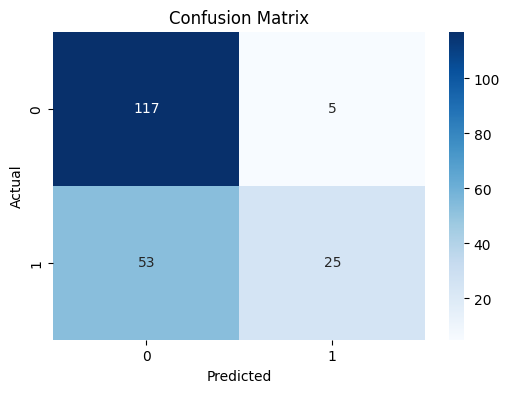

In [17]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class BernoulliNaiveBayes:
    def __init__(self, alpha=0.5):
        self.class_probs = {}
        self.feature_probs = {}
        self.classes = []
        self.alpha = alpha  # Parameter smoothing

    def fit(self, X, y):
        # Dapatkan semua kelas unik
        self.classes = np.unique(y)
        total_samples = len(y)

        # Hitung probabilitas setiap kelas (prior)
        self.class_probs = {cls: np.sum(y == cls) / total_samples for cls in self.classes}

        # Hitung probabilitas setiap fitur untuk setiap kelas
        self.feature_probs = {cls: defaultdict(float) for cls in self.classes}

        for cls in self.classes:
            X_cls = X[y == cls]  # Data fitur untuk kelas tertentu
            cls_sample_count = X_cls.shape[0]
            feature_count = X_cls.shape[1]

            # Hitung probabilitas fitur dalam kelas (menggunakan Laplace smoothing dengan alpha)
            for feature in range(feature_count):
                feature_presence = np.sum(X_cls[:, feature] > 0)  # Jumlah kemunculan fitur
                self.feature_probs[cls][feature] = (feature_presence + self.alpha) / (cls_sample_count + 2 * self.alpha)

    def predict(self, X):
        predictions = []
        for sample in X:
            class_scores = {}

            for cls in self.classes:
                # Mulai dengan log dari probabilitas kelas (prior)
                class_scores[cls] = np.log(self.class_probs[cls])

                # Tambahkan log probabilitas fitur
                for feature_index in range(len(sample)):
                    feature_value = sample[feature_index]
                    if feature_value > 0:
                        class_scores[cls] += np.log(self.feature_probs[cls][feature_index])
                    else:
                        class_scores[cls] += np.log(1 - self.feature_probs[cls][feature_index])

            # Prediksi kelas dengan skor tertinggi
            predictions.append(max(class_scores, key=class_scores.get))

        return np.array(predictions)

# Membagi Data Latih dan Uji
def train_test_split(X, y, test_size=0.2, random_state=42):
    np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_set_size = int(len(X) * test_size)
    test_indices = indices[:test_set_size]
    train_indices = indices[test_set_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

# Fungsi untuk Menampilkan Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = pd.crosstab(y_true, y_pred, rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

# Data contoh (biner)
X = text_tf.toarray()
y = encoded_labels

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Inisialisasi model dengan alpha untuk Laplace smoothing
bnb = BernoulliNaiveBayes(alpha=1.0)

# Latih model dengan data latih
bnb.fit(X_train, y_train)

# Prediksi pada data uji
predictions = bnb.predict(X_test)
print("Prediksi:", predictions)
print("Label asli:", y_test)

# Evaluasi Akurasi
accuracy = np.sum(predictions == y_test) / len(y_test)
print("Akurasi:", accuracy)

# Tampilkan Confusion Matrix
plot_confusion_matrix(y_test, predictions)
